In [1]:
# Users need to execute the following to get the neural_network module

# ! git clone https://github.com/mkpro118/CS-539-project.git

# import sys
# sys.path.insert(0, 'CS-539-project')

In [2]:
# This experiment uses the ResNet50 pretrained network
# to learn the given data

import numpy as np

from data import load_data

# This experiment was to run using smaller images to execute faster than
# the original sized images and determine the upper limit of accuracy 
data = load_data('resized', size=(64, 64), depth_first=False)

X, y = data.data, data.labels
labels, names =  data.unique_labels, data.unique_label_names
input_shape = data.shape

print(f'X.shape      = {X.shape}')
print(f'y.shape      = {y.shape}')
print(f'labels.shape = {labels.shape}')
print(f'Label names  = {", ".join(names)}')

X.shape      = (651, 64, 64, 3)
y.shape      = (651,)
labels.shape = (5,)
Label names  = bishop, knight, pawn, queen, rook


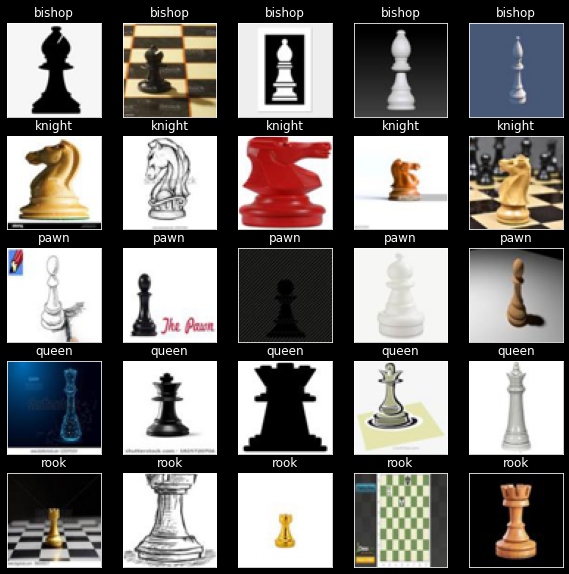

In [3]:
# Visualize the data
def sample(X, y, samples):
    unique_ys = np.unique(y, axis=0)
    result = []
    for unique_y in unique_ys:
        val_indices = np.argwhere(y==unique_y).flatten()
        random_samples = np.random.choice(val_indices, samples, replace=False)
        result.extend(map(lambda x:(x, unique_y), X[random_samples]))
    return result
    

_X = sample(X, y, 5)

%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use('dark_background')

fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))
axs = axs.flatten()
for i, (ax, (a, b)) in enumerate(zip(axs, _X)):
    ax.imshow(a)
    ax.set_title(f'{names[i // 5]}')
    ax.tick_params(
        left=False,
        labelleft=False,
        labelbottom=False,
        bottom=False
    )

plt.show()

In [4]:
# Partition the dataset
# Warning arises when the notebook is run in Google Colab
# where the system python version is <= 3.8,
# as not all typing features are supported

from neural_network.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

print(f'X_train.shape = {X_train.shape}')
print(f'y_train.shape = {y_train.shape}')
print(f'X_test.shape  = {X_test.shape}')
print(f'y_test.shape  = {y_test.shape}')

X_train.shape = (550, 64, 64, 3)
y_train.shape = (550,)
X_test.shape  = (101, 64, 64, 3)
y_test.shape  = (101,)


CS-539-project/neural_network/__init__.py:9: UserWarning: typing support is not fully compatible with python version 3.7.13
  warnings.warn('typing support is not fully compatible with python version ' + '.'.join((x, y, z)))
CS-539-project/neural_network/utils/typesafety.py:9: UserWarning: Cannot perform typesafety checks on subcripted annotations
  warnings.warn('Cannot perform typesafety checks on subcripted annotations')


In [5]:
# Cross validation splitter

from neural_network.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=3)
cv_splitter = skf.split(X_train, y_train)

In [6]:
# Catgorize labels

from neural_network.preprocess import OneHotEncoder

encoder = OneHotEncoder().fit(labels)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

print(f'y_train.shape = {y_train.shape}')
print(f'y_test.shape  = {y_test.shape}')

y_train.shape = (550, 5)
y_test.shape  = (101, 5)


In [7]:
# Prepocess input for ResNet50

from keras.applications.resnet import preprocess_input

for i in range(len(X_train)):
    X_train[i] = preprocess_input(X_train[i])

for i in range(len(X_test)):
    X_test[i] = preprocess_input(X_test[i])

In [8]:
# Define the model and train

from keras.models import Model
from keras.applications.resnet import ResNet50

base_model = ResNet50(weights='imagenet', include_top=False)

from keras.layers import Dense, GlobalAveragePooling2D, Dropout


x = base_model.output  
x = GlobalAveragePooling2D(name='avg_pool')(x)
x = Dropout(0.4)(x) 

predictions = Dense(5, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False


model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# instead of training multiple models, 
# we train the same model multiple times
# to better learn the data
for train, validate in cv_splitter:
    history = model.fit(
        X_train[train],
        y_train[train],
        epochs=50,
        batch_size=32,
        validation_data=(X_train[validate], y_train[validate])
    )

Epoch 1/50
12/12 [==============================] - 13s 812ms/step - loss: 6.4967 - accuracy: 0.2923 - val_loss: 3.8399 - val_accuracy: 0.3152
Epoch 2/50
12/12 [==============================] - 8s 680ms/step - loss: 3.7219 - accuracy: 0.3798 - val_loss: 7.9930 - val_accuracy: 0.2663
Epoch 3/50
12/12 [==============================] - 8s 686ms/step - loss: 4.9004 - accuracy: 0.3880 - val_loss: 4.1929 - val_accuracy: 0.4076
Epoch 4/50
12/12 [==============================] - 8s 661ms/step - loss: 3.9514 - accuracy: 0.4235 - val_loss: 4.3260 - val_accuracy: 0.4457
Epoch 5/50
12/12 [==============================] - 8s 671ms/step - loss: 2.8206 - accuracy: 0.5246 - val_loss: 3.3841 - val_accuracy: 0.3696
Epoch 6/50
12/12 [==============================] - 8s 657ms/step - loss: 2.6984 - accuracy: 0.5273 - val_loss: 3.4069 - val_accuracy: 0.4022
Epoch 7/50
12/12 [==============================] - 8s 676ms/step - loss: 2.1821 - accuracy: 0.5683 - val_loss: 4.1163 - val_accuracy: 0.3859
Epoch

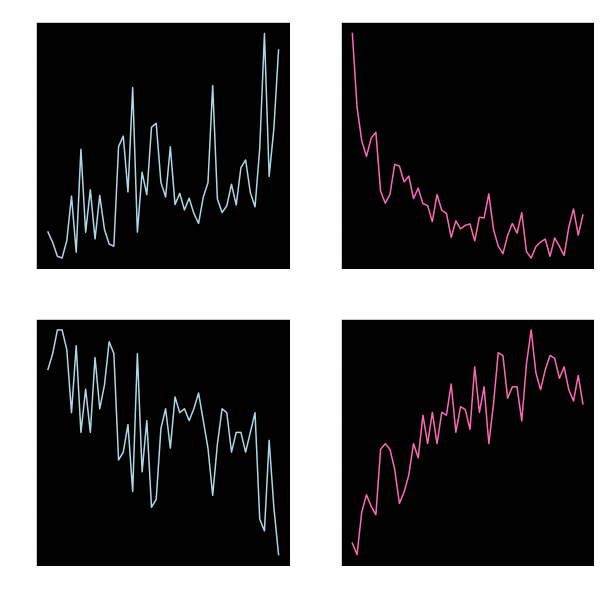

In [9]:
%matplotlib inline
from matplotlib import pyplot as plt

acc = history.history['accuracy']
loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = np.arange(1, len(acc) + 1)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))

ax1.plot(epochs, val_loss, color='lightblue')
ax1.set_title("Validation Loss")
ax2.plot(epochs, loss, color='hotpink')
ax2.set_title("Overall Loss")

ax3.plot(epochs, val_acc, color='lightblue')
ax3.set_title("Validation Accuracy")
ax4.plot(epochs, acc, color='hotpink')
ax4.set_title("Overall Accuracy")

plt.show()

In [10]:
# Well... can't beat 100% :(

model.evaluate(X_test, y_test)

4/4 [==============================] - 2s 342ms/step - loss: 0.0515 - accuracy: 1.0000


[0.05145562067627907, 1.0]

In [12]:
# predictions to plot confusion matrix
predictions = model.predict(X_test)

predictions = (predictions.argmax(axis=1)).astype(int)
predictions = encoder.transform(predictions)

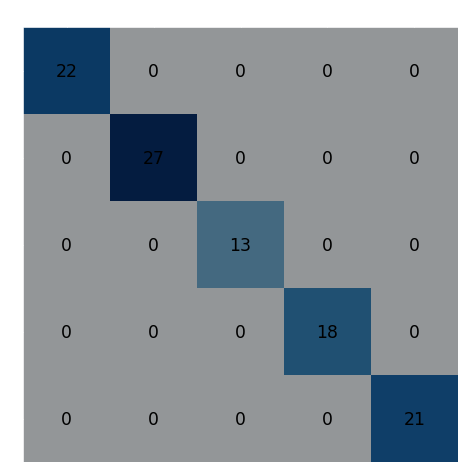

In [13]:
# The confusion matrix
from neural_network.metrics import confusion_matrix
cmat = confusion_matrix(y_test, predictions) 

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))

ax.matshow(cmat, cmap='Blues', alpha=0.6)
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(map(str, labels), fontsize=14)
ax.set_yticks(np.arange(len(labels)))
ax.set_yticklabels(map(str, labels), fontsize=14)

for i in range(cmat.shape[0]):
    for j in range(cmat.shape[1]):
        ax.text(x=j, y=i, s=cmat[i, j], va='center', 
                ha='center', size='xx-large', color='black')